# **🧙‍♂️ Wizard 🪄**
### Finding the optimized bidding strategy for the card game *Wizard* using a genetic algorithm
##### [Here](https://en.wikipedia.org/wiki/Wizard_(card_game)#Gameplay) are the rules.
---

We're going to use a [genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) in order to find the best strategy during the bidding phase of Wizard. 

There are many variables that go into the bidding round, I've defined some heuristics to start:
- High Card Weight
- Wizard Weight
- Jester Weight
- Trump Weight
- Position Bias
- Risk Bias
- Overbid Penalty Weight


---

### 🧬 Evolution Summary
This section reports the top-performing genome and how fitness evolved across generations.
- **Generations:** 75  
- **Population size:** 30 bots  
- **Elite count:** Top 10 preserved each generation  
- **Games per bot per generation:** 200  
- **Total evolved games:** ≈ 450,000  
- **Selection criteria:** Bots evaluated by total score over games with randomized player count and 2 fixed baselines



#### Imports:

In [45]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display
sys.path.append("pyFiles")
from genetic import evolve, validate_best_genome

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Run the genetic algorithm:

In [46]:
df_history, best_genome_data = evolve()
print("\n Evolution Complete")


 Evolution Complete


In [47]:
print("\n Best Genome Weights:")
best_genome_series = pd.Series(best_genome_data).round(3).sort_values(key=abs, ascending=False)
print(best_genome_series)


 Best Genome Weights:
trump_weight              1.107
position_bias            -1.014
wizard_weight             0.953
risk_bias                -0.600
high_card_weight          0.529
jester_weight            -0.159
overbid_penalty_weight    0.131
dtype: float64


#### Interpreting this data


---


### Testing our strategy:

In [ ]:
validation_df, bid_freq = validate_best_genome(best_genome_data, games=10000, num_players=5)


 Validation Results:
   Metric  Value
Avg Score   8.93
Hit Bid % 47.90%
    Games   1000

Bid Distribution (out of 1000 rounds):
0    206
1    213
2    234
3    214
4    110
5     20
6      3


<Axes: title={'center': 'Bid Distribution'}, xlabel='Bid', ylabel='Frequency'>

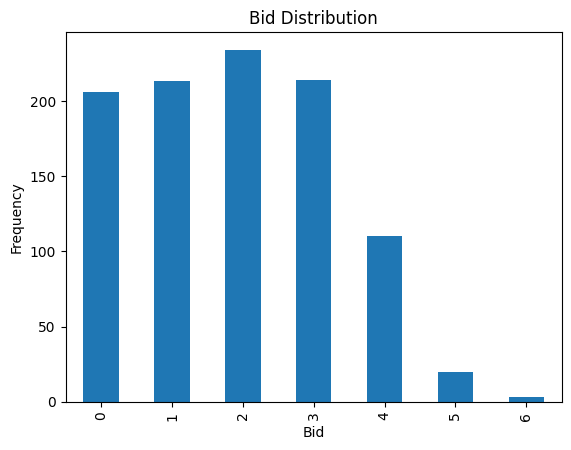

In [ ]:
print("\n Validation Results:")
print(validation_df.to_string(index=False))

print("\nBid Distribution (out of 10000 rounds):")
print(bid_freq.to_string())

bid_freq.plot(kind="bar", title="Bid Distribution", xlabel="Bid", ylabel="Frequency")
